In [1]:
import os
os.chdir('..')
os.getcwd()

import pandas as pd
import geopandas as gpd
from src import config

PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
# russian geo data
# https://www.kaggle.com/kapral42/russia-geo-data/version/1
# reading russian regions data (capitals coordinates)
rus_info_df = pd.read_csv("data/regions-info.csv")

# reading russian regions data (region bounds)
rus_bnd_gdf = gpd.read_file("data/geo.json")

In [4]:
# reading students data
students = pd.read_csv("data/preprocessed_data.csv")

E:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: DtypeWarning: Columns (57) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# creating united dataframes
rus_gdf = gpd.GeoDataFrame(rus_info_df, geometry=gpd.points_from_xy(rus_info_df.Longitude, rus_info_df.Latitude))
rus_gdf.crs = {'init': 'epsg:4326'}

rus_shape = rus_bnd_gdf[['NAME_1', 'TYPE_1', 'ID_1', 'geometry']]

rus_gdf_polygons = gpd.sjoin(rus_gdf, rus_shape, how="right", op='within')
rus_gdf_polygons = rus_gdf_polygons[rus_gdf_polygons["Region_eng"] != "Russia"]
rus_gdf_polygons = rus_gdf_polygons[~rus_gdf_polygons.Region_eng.isin(["Republic of Crimea", "Sevastopol"])]

rus_gdf_dots = gpd.sjoin(rus_gdf, rus_shape, how="left", op='within')

E:\Anaconda3\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
E:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3263: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):
<ipython-input-6-11eac7b61061>:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  rus_gdf_polygons = gpd.sjoin(rus_gdf, rus_shape, how="right", op='within')
E:\Anaconda3\lib\site-p

In [7]:
# casting region names
rus_gdf_polygons["merge_col"] = rus_gdf_polygons.Region_eng.apply(lambda x: config.REGION_TRANSLATION[x] if x in config.REGION_TRANSLATION else "другой город (РФ)")

In [8]:
# selecting state exams
math_df = students[["MACRO_BIRTH_PLACE", "MATH", "INFORMATICS"]].groupby("MACRO_BIRTH_PLACE").mean().reset_index()
rus_gdf_polygons = rus_gdf_polygons.merge(math_df, left_on="merge_col", right_on="MACRO_BIRTH_PLACE", how="left")

In [9]:
# plot utils
dots_cast = {
 "Mosow": "Moscow",
 "St. Petersburg": "St. Petersburg",
 "Republic of Tatarstan": "Kazan'",
 "Sverdlovsk region": "Yekaterinburg", 
# "Novosibirsk region" : "Novosibirsk", 
 "Kaliningrad region": "Kaliningrad",
}
colors = ["red", "snow", "orange", "pink", "yellow", "maroon"]
rus_gdf_dots["Region_eng"] = rus_gdf_dots["Region_eng"].apply(lambda x: dots_cast[x] if x in dots_cast else x)

In [40]:
# off-map values for ploting purposes (these two regions are not presented in the map). this is a hack for better map legend.
rus_gdf_polygons.loc[rus_gdf_polygons.Region_eng == "Primorsky Krai", "MATH"] = 75
rus_gdf_polygons.loc[rus_gdf_polygons.Region_eng == "Kamchatka Krai", "MATH"] = 95

rus_gdf_polygons.loc[rus_gdf_polygons.Region_eng == "Primorsky Krai", "INFORMATICS"] = 75
rus_gdf_polygons.loc[rus_gdf_polygons.Region_eng == "Kamchatka Krai", "INFORMATICS"] = 95

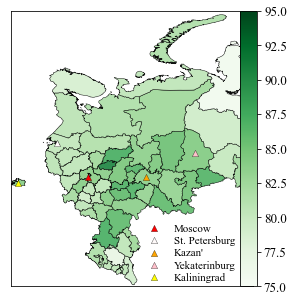

In [49]:
# plotting math map
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="4%", pad=-1.4)


fgx = rus_gdf_polygons.plot(column="MATH", ax=axs, cmap='Greens', edgecolor='black', alpha=0.9, linewidth=0.5, 
             legend=True, cax=cax)
for i, city in enumerate(list(dots_cast.values())):
    rus_gdf_dots[rus_gdf_dots["Region_eng"] == city].plot( color=colors[i], ax=axs, marker="^",
          markersize=40, edgecolor='black', linewidth=0.3)
axs.set_xlim(19.5, 75)
axs.set_ylim(41, 77.5)
axs.set_xticks([])
axs.set_yticks([])
fgx.figure.axes[1].tick_params(labelsize=13)

for i, city in enumerate(list(dots_cast.values())):
    axs.scatter([0], [0], c=colors[i], s=40, marker="^",
            label=city, edgecolor='black', linewidth=0.3)


axs.legend(scatterpoints=1, frameon=False,
        labelspacing=0.2, loc=(0.53, 0), fontsize=11, title_fontsize=20);
fig.savefig("gfx/map_math.pdf", bbox_inches='tight')
plt.show()

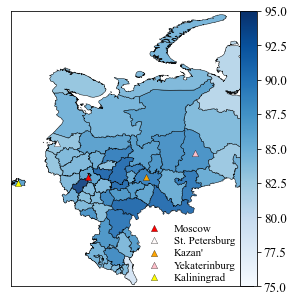

In [50]:
# plotting math map
fig, axs = plt.subplots(1, 1, figsize=(6, 6))
divider = make_axes_locatable(axs)
cax = divider.append_axes("right", size="4%", pad=-1.4)


fgx = rus_gdf_polygons.plot(column="INFORMATICS", ax=axs, cmap='Blues', edgecolor='black', alpha=0.9, linewidth=0.5, 
             legend=True, cax=cax)
for i, city in enumerate(list(dots_cast.values())):
    rus_gdf_dots[rus_gdf_dots["Region_eng"] == city].plot( color=colors[i], ax=axs, marker="^",
          markersize=40, edgecolor='black', linewidth=0.3)
axs.set_xlim(19.5, 75)
axs.set_ylim(41, 77.5)
axs.set_xticks([])
axs.set_yticks([])
fgx.figure.axes[1].tick_params(labelsize=13)

for i, city in enumerate(list(dots_cast.values())):
    axs.scatter([0], [0], c=colors[i], s=40, marker="^",
            label=city, edgecolor='black', linewidth=0.3)


axs.legend(scatterpoints=1, frameon=False,
        labelspacing=0.2, loc=(0.53, 0), fontsize=11, title_fontsize=20);
fig.savefig("gfx/map_informatics.pdf", bbox_inches='tight')
plt.show()

In [51]:
# creating per-year mean state exam df
plot_df = students[students["START_YEAR"] > "2015-09-01"][["START_YEAR", "MATH", "INFORMATICS"]].groupby("START_YEAR").mean().reset_index()
plot_df.START_YEAR = plot_df.START_YEAR.apply(lambda x: x.split('-')[0])

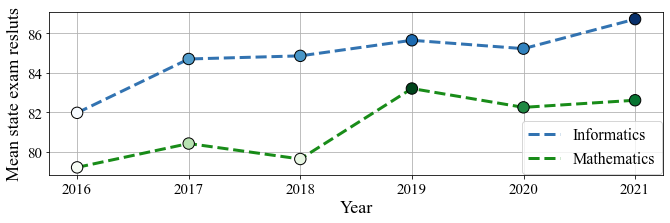

In [63]:
# trend plotting
fig = plt.figure(figsize=(11, 3))


plt.plot(plot_df.START_YEAR, plot_df.INFORMATICS, c="#1c64a9", zorder=10, linewidth=3, alpha=0.9,
         linestyle='--', label="Informatics")
plt.scatter(plot_df.START_YEAR, plot_df.INFORMATICS, c=plot_df.INFORMATICS, s=130,  
            edgecolor='black', 
            linewidth=1, cmap="Blues", zorder=100)


plt.plot(plot_df.START_YEAR, plot_df.MATH, c="Green", zorder=10, linewidth=3, alpha=0.9, linestyle='--', label="Mathematics")
plt.scatter(plot_df.START_YEAR, plot_df.MATH, c=plot_df.MATH,  cmap="Greens", 
            s=130,  
            edgecolor='black', 
            linewidth=1, zorder=100)


plt.legend(fontsize=16, loc=(0.77, 0.006))
plt.ylabel("Mean state exam resluts", fontsize=18)
plt.xlabel("Year", fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid()
fig.savefig("gfx/ege_trend.pdf", bbox_inches='tight')

plt.show()